# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

c:\Users\Matti\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Here I'll create a model like normal, using the same one from my solution for part 4.

In [2]:
from torch import nn, optim
from torch.nn.functional import log_softmax, relu


class Classifier(nn.Module):
    """Classifier network with dropout."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = relu(self.fc3(x))
        return log_softmax(self.fc4(x), dim=1)

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10, :])

tensor([[6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6],
        [6]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row. To avoid this, we use the `.view` method on `labels` to turn it into the same shape as `top_class`. (The `*top_class.shape` unpacks the shape values, so in this case it's the same as writing `labels.view(64, 1)`).

In [5]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item() * 100}%")

Accuracy: 15.625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for _ in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        with torch.no_grad():
            # validation pass here
            for images, labels in testloader:
                val_loss = criterion(model(images), labels)
                running_val_loss += val_loss.item()

                ps = torch.exp(model(images))       # Turn value form log to normal
                top_p, top_class = ps.topk(1, dim=1) # Get the index of the class with highest probability
                equals = top_class == labels.view(*top_class.shape) # Check if the predicted class is the same as the true class
                accuracy = torch.mean(equals.type(torch.FloatTensor)) # Calculate the accuracy

        ## TODO: Implement the validation pass and print out the validation accuracy
        print(f"Training loss: {running_loss/len(trainloader)}")
        print(f"Validation loss: {running_val_loss/len(testloader)}")
        print(f"Accuracy: {accuracy.item() * 100}%")

Training loss: 0.5131525844812139
Accuracy: 87.5%
Training loss: 0.391543147533433
Accuracy: 81.25%
Training loss: 0.35156799917981063
Accuracy: 87.5%
Training loss: 0.3293315787543493
Accuracy: 62.5%
Training loss: 0.31925608212950385
Accuracy: 81.25%
Training loss: 0.30138739443092205
Accuracy: 93.75%
Training loss: 0.2902887976055206
Accuracy: 93.75%
Training loss: 0.2815627546579853
Accuracy: 100.0%
Training loss: 0.2744374549639886
Accuracy: 93.75%
Training loss: 0.26472571315462273
Accuracy: 100.0%
Training loss: 0.2600937072457726
Accuracy: 93.75%
Training loss: 0.2531104518263452
Accuracy: 93.75%
Training loss: 0.24613747376400524
Accuracy: 100.0%
Training loss: 0.2484508437007221
Accuracy: 93.75%
Training loss: 0.2348634676416037
Accuracy: 100.0%
Training loss: 0.23210839840617262
Accuracy: 87.5%
Training loss: 0.2322847800476274
Accuracy: 93.75%
Training loss: 0.22385945383991515
Accuracy: 87.5%
Training loss: 0.2202853749134838
Accuracy: 93.75%
Training loss: 0.2155422183162

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    """Classifier network with dropout."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        """ Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [12]:
## TODO: Define your model with dropout added
from torch import nn, optim
from torch.nn.functional import log_softmax, relu


class Classifier(nn.Module):
    """Classifier network with dropout."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dp = nn.Dropout(p=0.2)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = self.dp(relu(self.fc1(x)))
        x = self.dp(relu(self.fc2(x)))
        x = self.dp(relu(self.fc3(x)))
        return log_softmax(self.fc4(x), dim=1)

In [15]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
val_loss_tracker = []
loss_tracker = []
epochs = 30
steps = 0

train_losses, test_losses = [], []
for _ in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss_tracker.append(loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        with torch.no_grad():
            model.eval()
            running_val_loss = 0
            # validation pass here
            for images, labels in testloader:
                val_loss = criterion(model(images), labels)
                val_loss_tracker.append(val_loss.item())
                running_val_loss += val_loss.item()

                ps = torch.exp(model(images))       # Turn value form log to normal
                top_p, top_class = ps.topk(1, dim=1) # Get the index of the class with highest probability
                equals = top_class == labels.view(*top_class.shape) # Check if the predicted class is the same as the true class
                accuracy = torch.mean(equals.type(torch.FloatTensor)) # Calculate the accuracy
            model.train()
        ## TODO: Implement the validation pass and print out the validation accuracy
        print(f"Training loss: {running_loss/len(trainloader)}")
        print(f"Validation loss: {running_val_loss/len(testloader)}")
        print(f"Accuracy: {accuracy.item() * 100}%")

Training loss: 0.604831603210745
Validation loss: 0.4718438008218814
Accuracy: 87.5%
Training loss: 0.4807510093362855
Validation loss: 0.43274573801429406
Accuracy: 93.75%
Training loss: 0.4540027865786542
Validation loss: 0.4342810645414765
Accuracy: 93.75%
Training loss: 0.437971533282098
Validation loss: 0.40337807158376
Accuracy: 81.25%
Training loss: 0.41571960579167044
Validation loss: 0.4008169343137437
Accuracy: 75.0%
Training loss: 0.4082079754550574
Validation loss: 0.41146304823790386
Accuracy: 75.0%
Training loss: 0.4034792597868295
Validation loss: 0.40749951058132633
Accuracy: 87.5%
Training loss: 0.395311193242828
Validation loss: 0.42543798592534793
Accuracy: 100.0%
Training loss: 0.3933980239511553
Validation loss: 0.39282501142495757
Accuracy: 87.5%
Training loss: 0.38709302597653383
Validation loss: 0.4011721351913586
Accuracy: 93.75%
Training loss: 0.3801299615550651
Validation loss: 0.38681672864658817
Accuracy: 75.0%
Training loss: 0.3817215682759976
Validation l

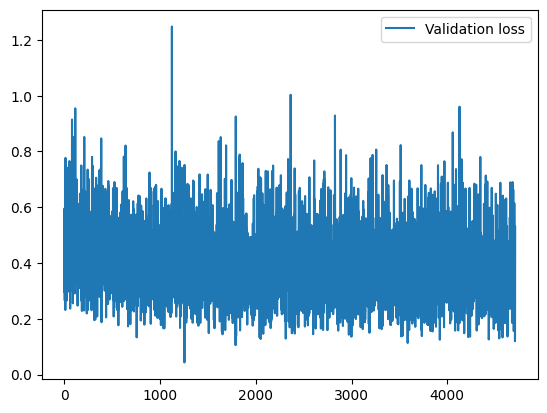

In [17]:
import matplotlib.pyplot as plt
# plt.plot(loss_tracker, label='Training loss')
plt.plot(val_loss_tracker, label='Validation loss')
plt.legend()
plt.show()

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

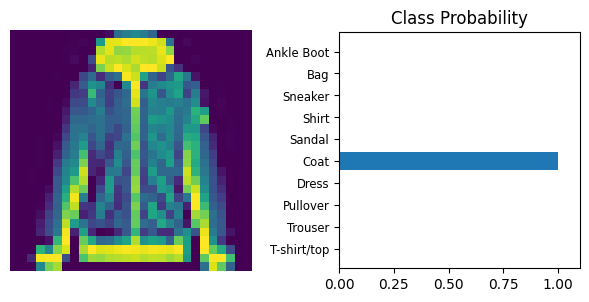

In [26]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version="Fashion")

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model every time you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.